# Modele dyfuzyjne (Denoising Diffusion Probabilistic Models)
## Wstęp
Modele dyfuzyjne to rodzina modeli generatywnych, które wykorzystują proces stopniowego zaszumiania próbki wejściowej (na przykład obrazu) w celu wyuczenia sieci neuronowej procesu odwrotnego - czyli usuwania szumu. Proces generowania startuje z czystego szumu, który sieć stopniowo stara się usunąć, co w konsekwencji prowadzi do wygenerowania zupełnie nowej próbki z modelowanego rozkładu. Proces zaszumiania nosi nazwę **procesu dyfuzji w przód** (forward diffusion process), a proces usuwania szumu z wykorzystaniem sieci to **proces dyfuzji wstecz** (reverse diffusion process).

<p align="center">
<img src="imgs/diffusion_abstract.png" width="800"/>
</p>
Generowanie nowych próbek składa się z wielu (nawet tysiąca) kroków odszumiających, co oznacza tysiąc przejść przez sieć. Wynik każdego z tych kroków możemy rozpatrywać jako zmienną losową, a ponieważ przejścia międzi nimi są zależne tylko od poprzedniego stanu (własność Markowa), to cały proces można opisać jako łańcuch Markowa. 

<p align="center">
<img src="imgs/markov_chain.png" width="500"/>
</p>

## Proces dyfuzji w przód (Forward diffusion process)
Cały proces w przód zaczyna się od czystej (niezaszumionej) próbki $x_0$ pochodzącej z rozkładu danych $q(x_0)$, który chcemy modelować. 
Możemy myśleć o $x_0$ jako o konkretnym zdjęciu, natomiast $q(x_0)$ jako o wszystkich możliwych (sensownych) zdjęciach. Proces w przód ma za zadanie 
wygenerować zaszumioną próbkę $x_t$ na podstawie oryginalnej próbki $x_0$, gdzie $t$ oznacza czas dyfuzji (ilość zaszumień). 
Im większe $t$ tym więcej szumu znajduje się w próbce $x_t$ i co za tym idzie tym mniej informacji o oryginalnej próbce $x_0$. 
Proces w przód jest tak skonstruowany, że dla pewnej liczby kroków (oznaczanej jako $T$ - zazwyczaj $T = 1000$) próbka $x_T$ jest nierozróżnialna od czystego szumu $\mathcal{N}(0, 1)$. Innymi słowy rozkład $\mathcal{N}(0, 1)$ jest rozkładem stacjonarnym łancuchu Markova opisującego proces w przód.

Proces w przód definiujemy poprzez 
$$ q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbb{I}), \tag{1} $$
gdzie $x_{t-1}$ to stan poprzedni, natomiast $\beta_t$ to tzw. *noise scheduler*, który określa siłę zaszumienia w kroku $t$. Wartości $\beta_t$ są zazwyczaj niewielkie (np. $0.01$), co sprawia, że pojedynczy krok niewiele zmienia wygląd próbki $x_{t-1}$, jednak nałożenie na siebie wielu takich kroków (np. 1000) skutkuje stopniowym usunięciem całej informacji próbki $x_0$ na rzecz szumu. We wzorze widzimy także, że poprzednia próbka zostaje delikatnie zmniejszona (ponieważ $\sqrt{1 - \beta_t}$ jest nieco mniejsze niż 1), co powoduje, że wariancja nie eksploduje do nieskończoności podczas dokładaniu szumu, a dąży do 1 (tzw. Variance Preserving, VP) i dzięki temu rozkładem stacjonarnym łańcucha Markova procesu w przód jest $\mathcal{N}(0, 1)$.

Przy tak zdefiniowanym procesie, jesteśmy w stanie otrzymać dowolne zaszumienie próbki $x_0$ poprzez wykonanie odpowiedniej liczby kroków w przód
$$ q(x_{1:T} | x_0) = \prod_{t=1}^{T} q(x_t | x_{t-1}). \tag{2}$$
Wielokrotne zaszumianie jest jednak kosztowne obliczeniowo, dlatego w praktyce korzysta się ze sztuczki pozwalającej otrzymać dowolny stan $x_t$ przy użyciu tylko jednego zaszumienia. W tym celu definiuje się zmienne pomocnicze
$$ \alpha_t = 1 - \beta_t, \qquad \bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i. \tag{3} $$
Przy wykorzystaniu tych definicji, otrzymujemy
$$ q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbb{I}), \tag{4} $$
które jest równoważne z wykonaniem $t$ razy równania (1). Wyprowadzenie wzoru (4) możecie znaleźć w [blogu](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

## Proces dyfuzji wstecz (Reverse diffusion process)
Potrafiąc odwracać proces w przód, potrafilibyśmy generować nowe próbki z modelowanego rozkładu danych. 
Niestety w praktyce, mimo, że rozkład $q(x_t | x_{t-1})$ jest prosty, to rozkład a posteriori $q(x_{t-1} | x_t)$ jest niemożliwy do policzenia.
Intuicyjnie ma to sens - nie znając rozładu danych $q(x_0)$, nie jesteśmy w stanie opisać wzorem mniej zaszumionej wersji $x_t$.
Mimo, że posterior $q(x_{t-1} | x_t)$ nie jest znany, to gdy dokonamy dodatkowego warunkowania czystą próbką $x_0$, rozkład $q(x_{t-1} | x_t, x_0)$ staje się możliwy do policzenia stosując twierdzenie Bayesa
$$ q(x_{t-1} | x_t, x_0) = \frac{q(x_t | x_{t-1}, x_0) q(x_{t-1} | x_0)}{q(x_t | x_0)}. \tag{5} $$
Jak widać, wszystkie składniki w powyższym wzorze odnoszą się do wcześniej zdefiniowanego procesu dyfuzji w przód i są znane (równania (1) i (4)). 
Gdy wszystkie rozkłady po prawej stronie równania (5) zastąpimy definicją rozkładu w przód i dokonamy wielu przekształceń, dostaniemy
$$ q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\left(x_{t-1}; 
\frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0,
\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t \mathbb{I}
\right). \tag{6} $$ 
Ten wzór nie wygląda zbyt zachęcająco i ciężko zrozumieć co opisuje patrząc się na jego definicję. Warto natomiast pamiętać, że intuicyjnie chcemy dostać rozkład prawdopodobnych wersji mniej zaszumionego zdjęcia $x_t$.

Mając wzór na posterior procesu w przód (6), definiujemy proces dyfuzyjny wstecz 
$$ p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)) \tag{7}$$
o wyuczalnych parametrach $\theta$, który ma za zadanie jak najlepiej estymować (6). 
Proces wstecz zaczyna z rozkładu bazowego $p(x_T) = \mathcal{N}(0, 1)$ i aplikuje T razy równanie (7), by otrzymać estymatę $x_0$. $\mu_\theta$ oraz $\Sigma_theta$ to teoretyczne sieci neuronowe, odpowiedzialne za przewidywanie średnich i wariancji mniej zaszumionych $x_t$, natomiast takie rozwiązanie nie jest wykorzystywane w praktyce, a służy jedynie teoretycznym wyznaczeniom modelu. Jak się później okaże, w praktyce wystarczy nam jedna sieć do predykcji szumu zawartego w próbce $x_t$.

## Funkcja straty
Teoretyczną funkcją straty dla modelu dyfuzyjnego jest negatywny logarytm wiarygodności (negative log-likelihood). Nie jest on jednak policzalny z uwagi na zależność między kolejnymi krokami w procesie dyfuzji. W praktyce, wykorzystuje się zatem *Evidence Lower Bound* (ELBO),
$$ 
- log(p_\theta(x_0)) \leq - log(p_\theta(x_0)) + D_{KL}(q(x_{1:T} | x_0) || p_\theta(x_{1:T}|x_0)). \tag{8} 
$$
Po bardzo długich przekształceniach otrzymujemy nierówność 
$$
- log(p_\theta(x_0)) \leq \sum_{t=1}^T D_{KL}(q(x_{t-1} | x_t, x_0) \; || \; p_\theta(x_{t-1} | x_t)). \tag{9}
$$
Zatem minimalizując dywergencję Kullbacka-Leiblera pomiędzy wyuczalnym procesem wstecz $p_\theta$, a odpowiadającym posteriorem procesu w przód, minimalizujemy teoretyczny NLL. 

- Jak można zaobserwować z równań (6) i (7), oba te rozkłady są rozkładami Gaussa, a dywergencja KL pomiędzy dwoma Gaussami jest znana ([link](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Examples)).
- Dodatkowo, warto zauważyć, że wariancja w (6) nie zależy od danych (brak $x_0$ czy też $x_t$ itp), co oznacza, że wariancja jest znana i nie trzeba jej optymalizować w procesie (7) - istotna jest jedynie średnia $\mu_\theta(x_t, t)$.

Te obserwacje i szereg kolejnych obliczeń (pokazanych w [blogu](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)) doprowadza nas ostatecznie do bardzo podstawowej funkcji straty (MSE)
$$
\mathcal{L} = \sum_{t=1}^T \frac{(1 - \alpha_t)^2}{2 \alpha_t (1 - \bar{\alpha}_t) || \Sigma ||_2^2} || \epsilon_t - 
\epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t, t) ||^2, \tag{10}
$$
gdzie $\epsilon_t$ to szum obecny w próbce $x_t$, którą chcemy odszumić, natomiast $\epsilon_\theta$ to model predykcji szumu, który dostaje próbkę $x_t$ zgodnie z wzorem (4) o szumie $\epsilon_t$. 
Powyższy wzór można uprościć pozbywając się wyrazów wolnych, niezależnych od $\theta$, co według [[2]](https://arxiv.org/pdf/2006.11239) poprawia stabilność modelu
$$
\mathcal{L}_{ \text{simple} } = \sum_{t=1}^T || \epsilon_t - 
\epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t, t) ||^2. \tag{11}
$$

W praktyce w trakcie treningu dla każdej próbki w batchu:
- zamiast iterować po wszystkich krokach i sumować błąd, dla każdej próbki losujemy niezależnie jeden krok $t$
- zaszumiamy $x_0$ do $x_t$ zgodnie z (4)
- predykujemy szum obecny w $x_t$ i wyznaczamy MSE między rzeczywistym szumem $\epsilon_t$, a wynikiem modelu $\epsilon_\theta$.

## Dodatkowe materiały
Materiały posegregowane wg ilości detali.
- Video na temat dyfuzji: [youtube](https://www.youtube.com/watch?v=HoKDTa5jHvg)
- Omówienie artykułu DDPM: [youtube](https://www.youtube.com/watch?v=W-O7AZNzbzQ)
- Blog na temat dyfuzji: [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

In [2]:
import os
import gdown
import torch
import math
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.linalg import sqrtm  # noqa: E501 (funkcja przydatna w jednym z rozwiązań)
from tqdm import tqdm

from src.models import SmallDenoiserNetwork, LargeConvDenoiserNetwork, InceptionV3
from src.datasets import MoonsDataset, CIFAR10Dataset
from src.visuals import visual_comparison, plot_loss_curve, plot_trajectories, show_images, plot_image_trajectories
from src.unittests import DDPMTests, DDIMTests

/home/mindflayer77/miniconda3/envs/pgm-lab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NUMBER_OF_SAMPLES = 5000 # definiujemy ile próbek ma znaleźć się w zbiorze danych, oraz ile chcemy generować przez model (dla porównania)
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)

print("Używasz:", DEVICE) # zalecane korzystanie z GPU

Używasz: cpu


Inicjalizujemy zbiór danych Moons (2D) z 1000 próbkami. Wizualizujemy wspomniany zbiór, porównując go do naszego rozkładu a priori - rozkładu normalnego.

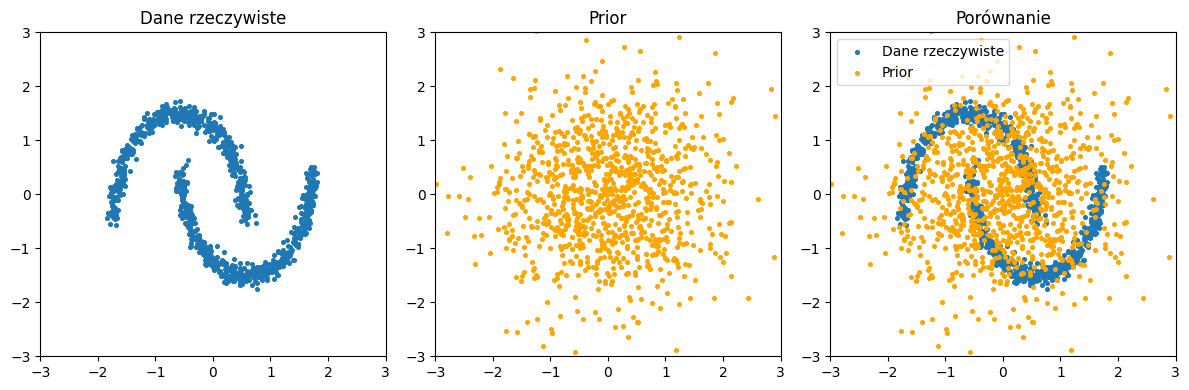

In [4]:
ds = MoonsDataset(NUMBER_OF_SAMPLES)
prior = torch.randn(NUMBER_OF_SAMPLES, 2)

visual_comparison(ds.samples(), prior, ["Dane rzeczywiste", "Prior"])

Funkcja `apply` to funkcja pomocnicza do przemnażania wartości *noise schedulera* ($\beta$, $\alpha$, $\bar{\alpha}$ itp) z wektorami z przestrzeni danych ($x_0$, $x_t$, $\epsilon$ itp) o czasach dyfuzyjnych $t$. 

- Podając jako `coefficients` (na przykład $\alpha$) podajemy wartości dla wszystkich możliwych kroków tzn $\alpha_0, \alpha_1, ..., \alpha_T$.
- `timesteps` to wektor kroków dyfuzyjnych, różnych dla każdej z próbek w batchu. Dla przykładu $t = [123, 500, 25, 740]$ stworzy sekwencje $[\alpha_{123}, \alpha_{500}, \alpha_{25}, \alpha_{740}]$, która zostanie przemnożona przez kolejne próbki w batchu $x$ tzn $[\alpha_{123} \cdot x^{(1)}, \alpha_{500} \cdot x^{(2)}, \alpha_{25} \cdot x^{(3)}, \alpha_{740} \cdot x^{(4)}]$

Funkcja `apply` znacząco ułatwia zapis równań procesów dyfuzyjnych w kodzie i obsługuje jednoczesne przetwarzanie wielu próbek o różnych krokach dyfuzyjnych. Zanim przejdziesz dalej, upewnij się, że rozumiesz jej działanie.

In [5]:
def apply(
        coefficients: np.array, 
        timesteps: torch.tensor, 
        x: torch.tensor
        ):
    """
    Wyznacza współczynniki z aktualnych kroków dyfuzyjnych i przemnaża je przez tensor x.

    :param coefficients: 1D numpy array, wartości współczynników noise scheduler'a (np alpha, beta itp) dla wszystkich 1000 kroków
    :param timesteps: 1D tensor, wartości kroków dyfuzjnych dla każdej z próbki w batchu
    :param x: tensor, batch wartości z domeny danych (czystych bądź zaszumionych)
    :return: tensor, wynik przemnożenia coefficients[t] * x. Wynik posiada taki sam rozmiar jak x.
    """
    factors = torch.from_numpy(coefficients).to(device=timesteps.device)[timesteps].float() 
    K = x.dim() - 1 # ilość osi w x (minus 1 bo nie liczymy batch size), dla danych Moons jest to 1, dla obrazów jest to 3 (kanał, szerokość, wysokość)
    factors = factors.view(-1, *([1]*K)).expand(x.shape) # tworzymy puste osie, żeby można przemnożyć mnożniki przez x
    return factors * x


### Zadanie 1 (2 punkty)
Korzystając z wartości `betas`, `alphas`, `alphas_bar`, `alphas_bar_prev`, a także funkcji `apply` zaimplementuj:
- metodę `q_sample`, która reprezentuje proces w przód (zaszumianie danych). Na podstawie $x_0$, $t$ i $\epsilon$ zwraca $x_t$ zgodnie z (4),
- metodę `q_posterior`, która reprezentuje posterior procesu w przód z równania (6) (odszumianie danych),
- metodę `train_step`, która dla batcha zdjęć $x_0$ zwróci uproszczoną funkcję straty (11) dla losowych $t$. Upewnij się, że **nie** używasz tego samego $t$ dla wszystkich próbek w batchu.

**Uwaga**: Pamiętaj, żeby nigdzie nie definiować na sztywno wymiarowości danych (np. podczas generowania szumu). Zamiast tego, powinno się odwoływać do kształtu wejść (np. torch.randn_like(x)). Dzięki temu klasa dyfuzji będzie działać dla dowolnych danych (co później zostanie zademonstrowane na przykładzie zbioru CIFAR). 

In [6]:
class GaussianDiffusion:
    """
    Podstawowa klasa architektury DDPM. 
    """
    def __init__(self, num_timesteps=1000):
        self.num_timesteps = num_timesteps
        self.timesteps = list(range(self.num_timesteps))[::-1]

        self.betas = np.linspace(start=0.0001, stop=0.02, num=self.num_timesteps)
        self.setup_noise_scheduler(self.betas)

    def setup_noise_scheduler(self, betas):
        self.alphas = 1.0 - betas
        self.alpha_bars = np.cumprod(self.alphas, axis=0)
        self.alpha_bars_prev = np.append(1.0, self.alpha_bars[:-1])

    def q_sample(self, x_0, t, noise=None):
        """
        próbkowanie z rozkładu q(x_t | x_0). dodaje szum do próbki x_0 o sile zgodnie ze znacznikiem czasowym t.

        :x_0: batch czystych próbek do zaszumienia
        :t: wektor znaczników czasowych. Każda próbka ma swój niezależny czas.
        :noise: Szum nakładany na próbkę x_0, przeskalowany zgodnie z wartościami schedulera. 
                Gdy szum nie został podany, jest on próbkowany z rozkładu Gaussa
        :return: x_t - batch zaszumionych próbek x_0 do chwili czasowej t
        """
        if noise is None:
            noise = torch.randn_like(x_0)


        # POCZĄTEK ROZWIĄZANIA
        mean = apply(np.sqrt(self.alpha_bars), t, x_0)
        std = apply(np.sqrt(1 - self.alpha_bars), t, noise)

        return mean + std
        # KONIEC ROZWIĄZANIA

    def q_posterior(self, x_t, x_0, t, noise=None):
        """
        próbkowanie z rozkładu q(x_{t-1} | x_t, x_0). Usuwa część szumu, modelując jak powinna wyglądać próbka x_{t-1}, by x_t była prawdopodobna.

        :x_t: batch zaszumionych próbek w chwili t
        :x_0: batch czystych próbek 
        :t: wektor znaczników czasowych. Każda próbka ma swój niezależny czas.
        :noise: szum służący do wypróbkowania konkretnego x_{t-1} z rozkładu a posteriori, które ma rozkład Gaussa.
        :return: x_{t-1} - batch delikatnie odszumionych próbek w chwili czasowej t-1. 
        """
        if noise is None:
            noise = torch.randn_like(x_0)


        # POCZĄTEK ROZWIĄZANIA
        denom = 1 - self.alpha_bars
        x_t_coeff = (np.sqrt(self.alphas)*(1 - self.alpha_bars_prev)) / denom
        x_0_coeff = (np.sqrt(self.alpha_bars_prev) * self.betas) / denom

        mean = apply(x_t_coeff, t, x_t) + apply(x_0_coeff, t, x_0)

        var = ((1 - self.alpha_bars_prev)* self.betas) / denom
        std = np.sqrt(var)

        std_noise = apply(std, t, noise)

        return mean + std_noise
        # KONIEC ROZWIĄZANIA

    def _predict_x_0_from_eps(self, x_t, t, eps):
        """
        Estymuje x_0 na bazie zaszumionych próbek x_t, szumu jaki się w nich znajduje eps, oraz znacznika czasowego t. 
        Można łatwo wyznaczyć ten wzór przekształcając wzór (4) (stosując sztuczkę z reparametryzacją).

        :x_t: zaszumione próbki x_t
        :t: znaczniki czasowe. Różne dla innych próbek w batchu
        :eps: szum obecny w x_t
        :return: próbki x_0 stworzone poprzez usunięcie szumu eps z próbek x_t.
        """
        return (
            apply(np.sqrt(1.0 / self.alpha_bars), t, x_t) - 
            apply(np.sqrt(1.0 / self.alpha_bars - 1.0), t, eps)
        )

    def _predict_eps_from_xstart(self, x_t, t, x_0):
        """
        Estymuje szum w próbce x_t na bazie zaszumionych próbek x_t, czystych zdjęć x_0, oraz znacznika czasowego t. 
        Można łatwo wyznaczyć ten wzór przekształcając wzór (4) (stosując sztuczkę z reparametryzacją).

        :x_t: zaszumione próbki x_t
        :t: znaczniki czasowe. Różne dla innych próbek w batchu
        :x_0: Czyste próbki, bądź estymaty czystych próbek.
        :return: próbki x_0 stworzone poprzez usunięcie szumu eps z próbek x_t.
        """
        return (
            apply(np.sqrt(1.0 / self.alpha_bars), t, x_t) - x_0
        ) / apply(np.sqrt(1.0 / self.alpha_bars - 1.0), t, torch.ones_like(x_t))

    def train_losses(self, model, x_0):
        """
        Funkcja która zwraca wartość funkcji straty z wzoru (11) dla pewnego batcha czystych próbek x_0 oraz modelu.
        Funkcja próbkuje losowe znaczniki czasowe, oraz szum aplikowany do danych x_0. 
        Następnie za pomocą q_sample tworzy zaszumione dane x_t zgodnie z definicją procesu w przód.
        Model predykuje wartość szumu na podstawie danych x_t oraz znacznika t. 
        Ostateczny wynik to MSE pomiędzy prawdziwym (wcześniej wypróbkowanym) szumem, a tym wypredykowanym przez model

        :model: odszumiająca sieć neuronowa, której rolą jest predykować szum 
        :x_0: Prawdziwe dane, na których uczymy model. 
        :return: wartość błedu średniokwadratowego pomiędzy prawdziwym a predykowanym szumem Gaussowskim
        """
        # POCZĄTEK ROZWIĄZANIA
        noise = torch.randn_like(x_0)
        t = torch.randint(0, self.num_timesteps, (x_0.shape[0],), device=x_0.device)
        x_t = self.q_sample(x_0, t, noise)
        eps_0 = model(x_t, t)
        loss = F.mse_loss(noise, eps_0)
        # KONIEC ROZWIĄZANIA

        return loss

    @torch.no_grad()
    def p_sample_loop(
        self, 
        model: nn.Module, 
        noise: torch.tensor, 
        num_inference_steps: int = 1000,
        return_trajectory: bool = False, 
        clip: bool = False,
        quiet: bool = True
        ):
        """
        Proces dyfuzyjny wstecz służący do generowania nowych próbek. 
        Proces ten zaczyna się na czystym szumie, który jest wielokrotnie poddawany stopniowemu
        odszumianiu z wykorzystaniem sieci neuronowej. 

        :model: sieć neuronowa predykująca szum. Na podstawie jej wyników dokonywane jest generowanie danych
        :noise: szum startowy. Wygenerowanie dane będą posiadały dokładnie ten sam wymiar
        :num_inference_steps: Ilość kroków dyfuzyjnych w procesie próbkowania. Im więcej tym lepsze wyniki modelu, ale wolniejsza inferencja
        :return_trajectory: czy zwracać wyniki kroków pośrednich x_t dla wszystkich 1000 kroków (dla celów wizualizacyjnych)
        :clip: Czy aplikować clip do przedziału danych na estymaty x_0 w każdym kroku. Szczególnie użyteczne dla zdjęć.
        :quiet: czy nie wyświetlać paska postępu

        :return: ostateczne próbki jako macierz numpy. Gdy return_trajectory jest True - dodatkowo sekwencje x_t
        """
        self._respace(num_timesteps=num_inference_steps)

        x_t = noise
        bsz = x_t.shape[0]
        trajectory = [x_t.clone().cpu()]

        # iterujemy zaczynając od T i zmniejszając kroki aż do 0
        pbar = tqdm(enumerate(self.timesteps), desc='Próbkowanie', total=self.num_timesteps) if not quiet else enumerate(self.timesteps)

        for idx, time in pbar:
            t = torch.tensor([time] * bsz, device=x_t.device).long()
            i = torch.tensor([self.num_timesteps - idx - 1] * bsz, device=x_t.device).long()

            # próbkuj szum poprzez model i wyznacz estymatę x_0 
            eps = model(x_t, t)
            x_0 = self._predict_x_0_from_eps(x_t, i, eps)

            # W sytuacji kiedy model operuje na zdjęciach, często normalizujemy zdjęcia do przedziału (-1,1)
            # Gdy w każdym kroku clipujemy estymację czystej próbki x_0 do tego samego przedziału zwiększa to stabilność modelu
            if clip:
                x_0 = x_0.clamp(-1, 1)

            # krok odszumiający przy wykorzystaniu wzoru na posterior procesu w przód
            x_t = self.q_posterior(x_t, x_0, i)

            # dodanie x_t do celów wizualizacyjnych (nie ma wpływu na działanie metody)
            trajectory.append(x_t.clone().cpu())

        self._respace(1000) # na koniec wracamy do domyślnych 1000 kroków

        if return_trajectory:
            return x_0.cpu().numpy(), torch.stack(trajectory, dim=0).numpy()
        return x_0.cpu().numpy()
    
    def _respace(self, num_timesteps):
        """
        Funkcja zmieniająca ilość kroków dyfuzyjnych w inferencji. 
        Redukcja kroków wiąże się z szybszą inferencją kosztem gorszej jakości.
        Wartości noise scheduler'a muszą zostać dopasowane, ponieważ różnice pomiędzy x_{t-1} a x_t ulegają zmianie

        :num_timesteps: nowa ilość kroków dyfuzyjnych.
        """
        betas = np.linspace(start=0.0001, stop=0.02, num=1000)
        self.setup_noise_scheduler(betas) 

        self.num_timesteps = num_timesteps
        self.timesteps = np.linspace(999, 0, self.num_timesteps, dtype=int, endpoint=True)

        last_alpha_cumprod = 1.0

        self.betas = []

        for i, alpha_bar in enumerate(self.alpha_bars):
            if i in self.timesteps:
                self.betas.append(1 - alpha_bar / last_alpha_cumprod)
                last_alpha_cumprod = alpha_bar
        
        self.betas = np.array(self.betas)
        self.setup_noise_scheduler(self.betas)

### Wizualizacja procesu dyfuzji w przód
Dla coraz większych kroków, ustrukturyzowane dane powinny stopniowo zmieniać się w czysty szum Gaussa.

In [7]:
diffusion = GaussianDiffusion()

In [8]:
ddpm_tests = DDPMTests(diffusion, DEVICE)
ddpm_tests.run_tests()
print("Wszystkie testy przeszły pomyślnie!")

Wszystkie testy przeszły pomyślnie!


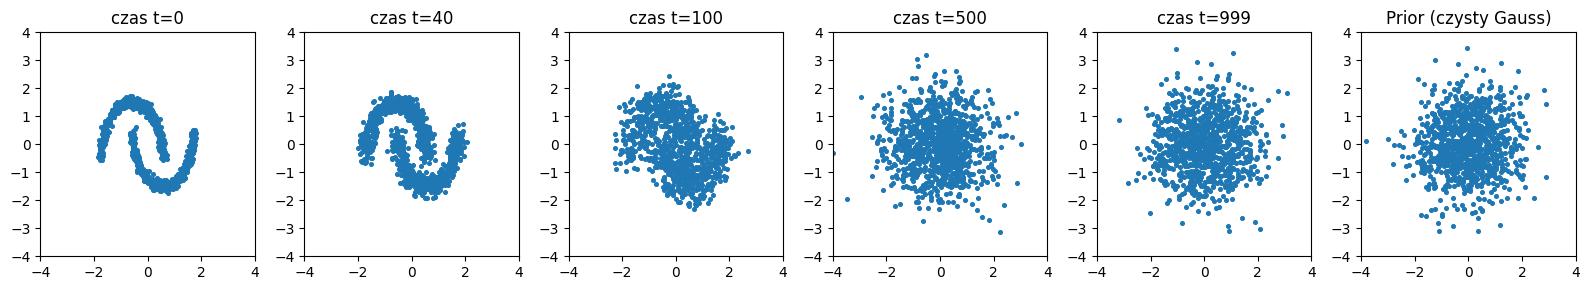

In [9]:
x_0 = ds.samples()

plt.figure(figsize=(16, 3))

plt.subplot(1, 6, 1)
plt.scatter(x_0[:1000, 0], x_0[:1000, 1], s=7)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("czas t=0")

for i, t in enumerate([40, 100, 500, 999]):
    plt.subplot(1, 6, i + 2)
    x_t = diffusion.q_sample(x_0, torch.tensor([t] * NUMBER_OF_SAMPLES))
    plt.scatter(x_t[:1000, 0], x_t[:1000, 1], s=7)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.title(f"czas t={t}")

plt.subplot(1, 6, 6)
plt.scatter(prior[:1000, 0], prior[:1000, 1], s=7)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Prior (czysty Gauss)")

plt.tight_layout()
plt.show()

Otrzymany wynik powinien przypominać:

![example](imgs/forward_diffusion_example.png)

### Trening modelu dyfuzyjnego
Korzystając z zaimplementowanej przez Ciebie klasy dyfuzyjnej wytrenujmy prosty model (sieć MLP) na zbiorze danych Moons. Sieć na wejściu posiada trzy neurony (pozycja próbki na osi x, pozycja próbki na osi y, oraz krok dyfuzyjny $t$), na wyjściu sieć zwraca dwa neurony odpowiadające szumowi zaaplikowanymi na każdy z dwóch wymiarów.

Próbkowanie: 100%|██████████| 1000/1000 [00:09<00:00, 101.91it/s]


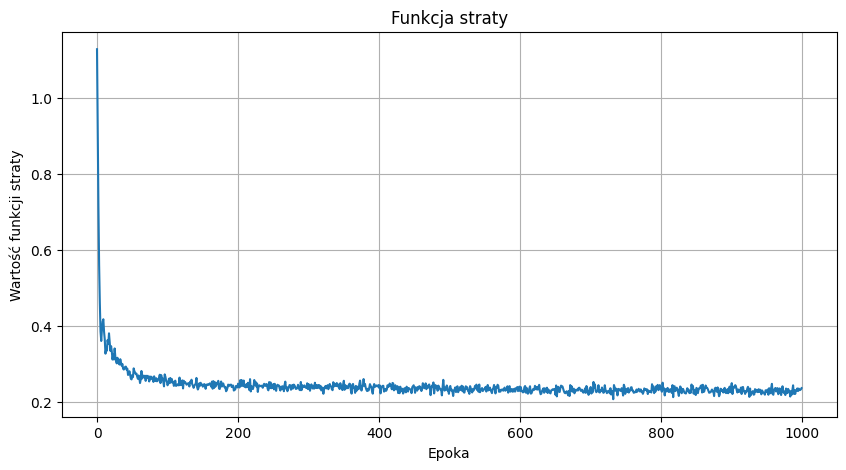

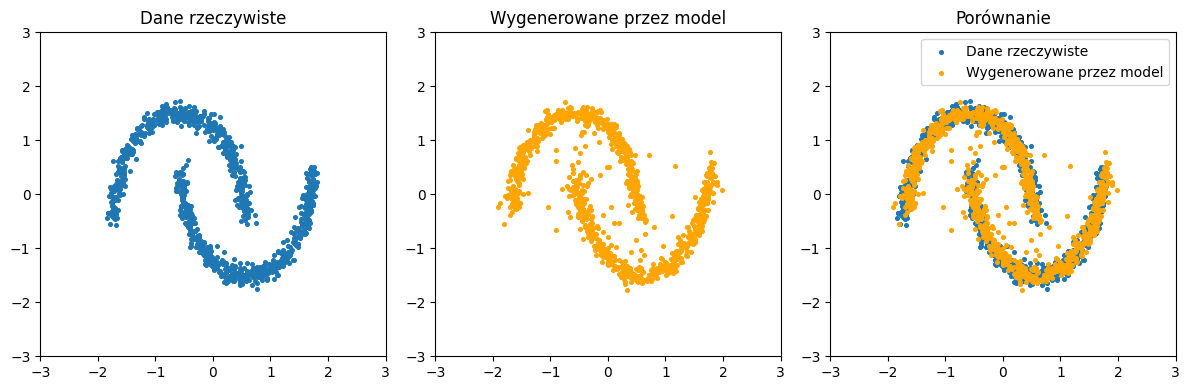

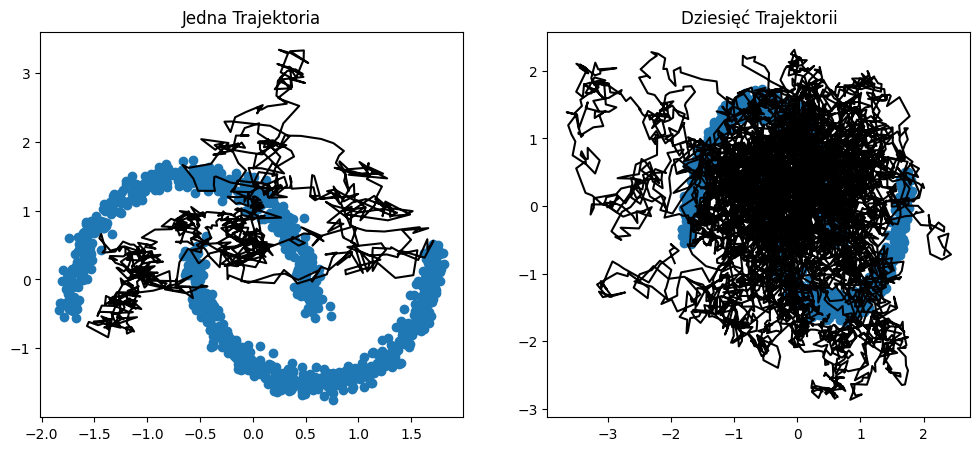

In [10]:
model_moons = SmallDenoiserNetwork().to(DEVICE)
ds = MoonsDataset(NUMBER_OF_SAMPLES)
dl = torch.utils.data.DataLoader(ds, batch_size=5000, shuffle=True)

ddpm = GaussianDiffusion()

optimizer = torch.optim.Adam(model_moons.parameters(), lr=5e-3)

loss_values = []

EPOCHS = 1000

pbar = tqdm(range(EPOCHS), desc='Trening')
for i in pbar:
    epoch_loss = []
    for x in dl:
        optimizer.zero_grad()
        loss = ddpm.train_losses(model_moons, x.to(DEVICE))
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    loss_values.append(sum(epoch_loss) / len(epoch_loss))
    pbar.set_postfix({'loss': loss_values[-1]})

ddpm_tests.assess_loss(loss_values)

samples, trajectories = ddpm.p_sample_loop(model_moons, torch.randn(NUMBER_OF_SAMPLES, 2, device=DEVICE), return_trajectory=True, quiet=False)

plot_loss_curve(loss_values)
visual_comparison(ds.samples(), samples, ["Dane rzeczywiste", "Wygenerowane przez model"])
plot_trajectories(ds, trajectories)


## Deterministyczne próbkowanie (DDIM, Denoising Diffusion Implicit Model)
Klasyczne modele dyfuzyjne wprowadzone w [[1](https://arxiv.org/pdf/1503.03585), [2](https://arxiv.org/pdf/2006.11239)] doczekały się wielu usprawnień w szeregu kolejnych publikacji [[3](https://arxiv.org/pdf/2010.02502), [4](https://arxiv.org/pdf/2206.00364), [5](https://arxiv.org/pdf/2210.02747)]. 
DDIM [[3](https://arxiv.org/pdf/2010.02502)] usprawnia proces próbkowania pozbywając się losowości we wzorze na posterior procesu w przód i traktując pojedynczy krok dyfuzyjny jako interpolacje pomiędzy $x_t$, a wstępną predykcją $x_0$. Tak zdefiniowany nowy posterior jest rozkładem jednopunktowym i wyraża się wzorem 
$$
q(x_{t-1} | x_t, x_0) = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1 - \bar{\alpha}_{t-1}} \frac{x_t - \sqrt{\bar{\alpha}_t}x_0}{\sqrt{1 - \bar{\alpha}_t}} \tag{12}
$$

Warto jednak zwrócić uwagę, że mimo, że posterior jest deterministyczny, to startujemy wciąż z rozkładu bazowego $\mathcal{N}(0, 1)$ co daje nam możliwość generowania losowych próbek. Dodatkowo, zwróć uwagę, że zmianie ulega tutaj tylko sposób próbkowania, a nie samego trenowania modelu, dzięki czemu nie musimy trenować nowej sieci.

### Zadanie 2 (1.5 punkta)
- Wzór (12) można zapisać w inny, bardziej zrozumiały sposób. W tym celu podstaw pod $x_t$ wzór (4) stosując sztuczkę z reparametryzacją (szum obecny w $x_t$ nazwij $\epsilon_t$). Uprość wzór maksymalnie i zapisz wnioski, porównując otrzymany wynik do wzoru (4).
- Zaimplementuj posterior DDIM zgodnie z otrzymanym równaniem. W celu ekstrakcji szumu $\epsilon_t$ obecnego w próbce $x_t$ użyj metody `self._predict_eps_from_xstart(x_t, t, x_0)` obecnej w klasie `GaussianDiffusion`. Zwizualizuj wyniki nowej metody próbkującej (korzystając z gotowej komórki poniżej) i napisz wnioski co uległo zmianie, a co jest podobnie w stosunku do DDPM.

Tu wyprowadź wzór i zapisz wnioski ...

$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_{t}
$$

$$
q(x_{t-1} \mid x_t, x_0) = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1 - \bar{\alpha}_{t-1}} \cdot \frac{x_t - \sqrt{\bar{\alpha}_t} x_0}{\sqrt{1 - \bar{\alpha}_t}} = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1 - \bar{\alpha}_{t-1}} \cdot \frac{\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_{t} - \sqrt{\bar{\alpha}_t} x_0}{\sqrt{1 - \bar{\alpha}_t}}
$$

$$
q(x_{t-1} \mid x_0) = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1 - \bar{\alpha}_{t-1}} \cdot \epsilon_{t}, \quad \epsilon_{t} \sim \mathcal{N}(0, \mathbb{I})
$$



$$
q(x_{t-1} \mid x_0) = \mathcal{N}\left(\sqrt{\bar{\alpha}_{t-1}} x_0,\; (1 - \bar{\alpha}_{t-1}) \mathbb{I} \right)
$$

Wzór po uproszeczeniu opisuje taki sam rozkład, tylko dla kroku t - t, więc cały proces możemy interpretować jako ciąg zależnych od siebie rozkładów Gaussa, gdzie jedynym parametrem zmieniającym się w czasie jest współczynnik $\bar\alpha_{t}$.


In [11]:
class DeterministicGaussianDiffusion(GaussianDiffusion):
    def q_posterior(self, x_t, x_0, t):
        """
        próbkowanie z rozkładu q(x_{t-1} | x_t, x_0) korzystając z metody DDIM.
        Usuwa część szumu, interpolując pomiędzy x_t a x_0

        :x_t: batch zaszumionych próbek w chwili t
        :x_0: batch czystych próbek 
        :t: wektor znaczników czasowych. Każda próbka ma swój niezależny czas.
        :noise: szum służący do wypróbkowania konkretnego x_{t-1} z rozkładu a posteriori, które ma rozkład Gaussa.
        :return: x_{t-1} - batch delikatnie odszumionych próbek w chwili czasowej t-1. 
        """
        # POCZĄTEK ROZWIĄZANIA
        noise = self._predict_eps_from_xstart(x_t, t, x_0)
        return apply(np.sqrt(self.alpha_bars_prev), t, x_0) + apply(np.sqrt(1 - self.alpha_bars_prev), t, noise)
        # KONIEC ROZWIĄZANIA

Wszystkie testy przeszły pomyślnie!


Próbkowanie: 100%|██████████| 1000/1000 [00:07<00:00, 139.56it/s]


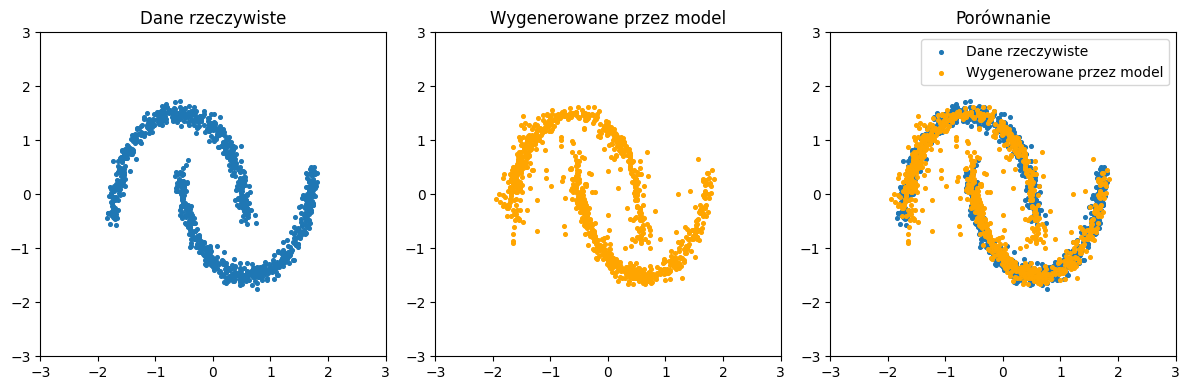

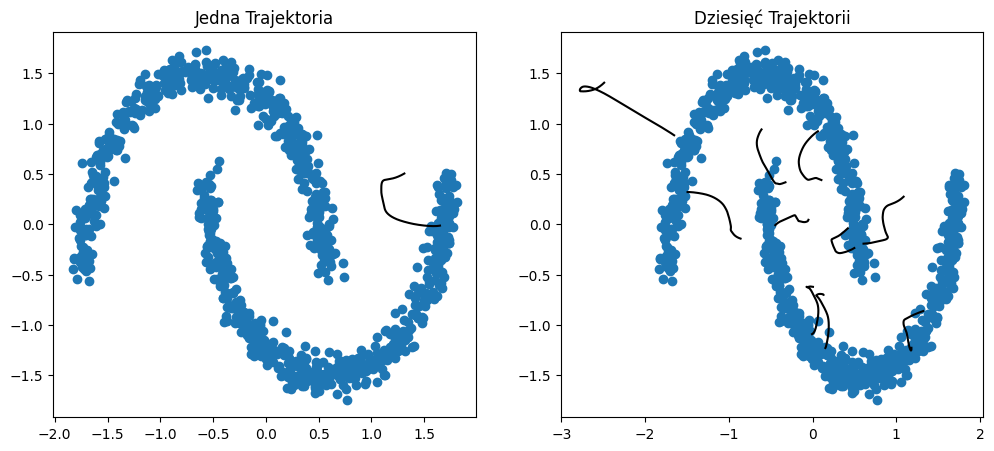

In [12]:
ddim = DeterministicGaussianDiffusion()

ddim_tests = DDIMTests(ddim, DEVICE)
ddim_tests.run_tests()
print("Wszystkie testy przeszły pomyślnie!")

samples, trajectories = ddim.p_sample_loop(model_moons, torch.randn(NUMBER_OF_SAMPLES, 2, device=DEVICE), return_trajectory=True, quiet=False)
visual_comparison(ds.samples(), samples, ["Dane rzeczywiste", "Wygenerowane przez model"])
plot_trajectories(ds, trajectories)

*Tu napisz wnioski i porównanie trajektorii DDIM z DDPM:* ...

## Dyfuzja na obrazach
Powyżej rozpatrywaliśmy bardzo prosty zbiór danych, posiadający tylko dwa wymiary. Modele dyfuzyjne bardzo dobrze skalują się jednak na bardziej złożone modalności. Poniżej będziemy operować na zbiorze danych CIFAR10, posiadającym obrazy przedstawiające obiekty 10 klas. Zdjęcia z tego zbioru są w rozdzielczości $32 \times 32$ i są w formacie RGB, co daje $32 \times 32 \times 3 = 3072$ wymiary. Wraz ze zwiększeniem zbioru danych musimy także zwiększyć nasz model predykcji szumu - zamiast prostej MLP będziemy korzystać z sieci U-Net, która idealnie nadaje się do przetwarzania obrazów. Dość duży U-Net został przez nas wcześniej wytrenowany na zbiorze CIFAR i jest gotowy do użycia przy próbkowaniu nowych zdjęć.

In [13]:
if not os.path.exists('checkpoints/best.pth'):
    url = "https://drive.google.com/uc?id=1BfgADqMLzgFLq7uvhuLLO6u9RFS99uND"
    os.makedirs('checkpoints', exist_ok=True)
    gdown.download(url, 'checkpoints/best.pth') 

model_cifar = LargeConvDenoiserNetwork()
model_cifar.load_state_dict(torch.load('checkpoints/best.pth', map_location='cpu'))
model_cifar.to(DEVICE)

image_ds = CIFAR10Dataset()

Downloading...
From (original): https://drive.google.com/uc?id=1BfgADqMLzgFLq7uvhuLLO6u9RFS99uND
From (redirected): https://drive.google.com/uc?id=1BfgADqMLzgFLq7uvhuLLO6u9RFS99uND&confirm=t&uuid=533519f0-2afa-4593-a6ca-605bfb7198b8
To: /home/mindflayer77/PycharmProjects/l09-Mindflayer77/checkpoints/best.pth
100%|██████████| 960M/960M [01:54<00:00, 8.36MB/s] 


100%|██████████| 170498071/170498071 [00:51<00:00, 3331220.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [14]:
N = 48
# wypróbkujmy N zdjęć ze zbioru CIFAR 
real = torch.stack([image_ds[i] for i in range(N)]).numpy()

# wypróbkujmy N zdjec przy uzyciu modelu i dyfuzji DDPM
generated_ddpm, traj_ddpm = ddpm.p_sample_loop(model_cifar, noise=torch.randn(N, 3, 32, 32, device=DEVICE), return_trajectory=True, clip=True, quiet=False)

# wypróbkujmy N zdjec przy uzyciu modelu i dyfuzji DDIM
generated_ddim, traj_ddim = ddim.p_sample_loop(model_cifar, noise=torch.randn(N, 3, 32, 32, device=DEVICE), return_trajectory=True, clip=True, quiet=False)

Próbkowanie:   0%|          | 1/1000 [00:04<1:18:10,  4.70s/it]

KeyboardInterrupt



In [ ]:
show_images(real, generated_ddpm, generated_ddim)

In [ ]:
plot_image_trajectories(traj_ddpm, traj_ddim)

## Metryki modeli generatywnych
Modele dyfuzyjne, jak i inne modele generatywne (Generatywne sieci przeciwstawne, Autokodery Wariacyjne, Normalizujące sieci przepływowe itp) potrafią generować nowe próbki danych bez jakichkolwiek informacji wejściowych. Z tego powodu, wygenerowane próbki nie posiadają swojego ground truth do którego możemy porównać nasze predykcje. Jak zatem ocenić jakość modelu, by być w stanie porównywać ze sobą różne architektury?

### FID
Postawione powyżej pytanie jest wciąż pytaniem otwartym, ponieważ nie istnieje idealna metryka dla modeli czysto generatywnych. Najbardziej popularną metryką jest FID (Frechet Inception Distance). Oto mechanizm jej działania:
- Pobieramy reprezentatywną próbę prawdziwych danych (np. $5000$ zdjęć ze zbioru CIFAR). Od ilości rozpatrywanych danych bierze się pełna nazwa metryki (np. FID-5k dla $5000$ próbek, lub FID-10k dla $10000$ próbek)*.
- Korzystając z wyuczonego modelu generatwynego próbkujemy tyle samo sztucznych zdjęć.
- Następnie, używając *innej* wytrenowanej sieci na podobnych danych (np. jakiegoś autokodera, lub klasyfikatora bez ostatniej warstwy) jako ekstraktora cech, osadzamy wszystkie zdjęcia prawdziwe i sztuczne do przestrzeni ukrytej.
- W przestrzeni ukrytej estymujemy dwa rozkłady Gaussa: osobno dla danych prawdziwych, oraz dla danych wygenerowanych przez nasz model generatywny.
- Porównujemy odległość dwóch Gaussów za pomocą odległości Wassersteina o wzorze
$$ d_{F}(\mathcal N(\mu, \Sigma), \mathcal N(\mu', \Sigma'))^2 = \lVert \mu - \mu' \rVert^2_2 + \operatorname{tr}\left(\Sigma + \Sigma' -2\left(\Sigma \Sigma'  \right)^\frac{1}{2} \right) \tag{13}$$ 

\* - *im więcej próbek, tym dokładniejsza metryka, lecz jej obliczenie trwa dłużej i potrzeba więcej danych testowych*.

### Zadanie 3 (1.5 punkta)
Zaimplementuj metrykę FID i wyznacz wartość FID-1k dla modelu `model_cifar` przy użyciu metod próbkujących DDPM i DDIM oraz różnej liczby kroków. Twoim zadaniem jest:
- implementacja funkcji `embed_generated_data`, która wypróbkuje 1000 zdjęć przy użyciu wytrenowanego modelu dyfuzyjnego, a następnie osadzi zdjęcia do przestrzeni ukrytej za pomocą sieci `inception_net`.
- implementacja funkcji `fit_n_dimensional_gaussian`, która dopasowywuje 2048-wymiarowego Gaussa (to jest rozmiar przestrzeni ukrytej ekstraktora cech) do 1000 osadzonych zdjęć
- implementacja fukcji `wasserstein_distance`, która liczy odległość Wassersteina dla dwóch Gaussów zgodnie ze wzorem (13).
 

In [ ]:
FID_SAMPLE_SIZE = 1_000
batch_size = 250 # można zwiększyć/zmniejszyć w zależności od posiadanej pamięci GPU
iterations = math.ceil(FID_SAMPLE_SIZE / batch_size)


@torch.no_grad()
def embed_real_data(ds, inception_net):
    real_latents = []

    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)
    for x in tqdm(dl, desc="Osadzanie", total=iterations):
        if len(real_latents)*batch_size >= FID_SAMPLE_SIZE:
            real_latents = real_latents[:FID_SAMPLE_SIZE]
            break

        x = x.to(DEVICE)
        z = inception_net(x)
        real_latents.append(z)


    real_latents = torch.cat(real_latents, dim=0).numpy()
    return real_latents


@torch.no_grad()
def embed_generated_data(model, sampler, num_timesteps, inception_net):
    """
    Funkcja generująca próbki za pomocą modelu (sieć odszumiająca) i samplera (DDPM bądź DDIM) i osadzająca je w przestrzeni ukrytej modelu inception_net

    :model: sieć odszumiająca, której rolą jest generowanie danych
    :sampler: sampler (DDPM bądź DDIM) który generuje dane zgodnie z procesem odwrotnym
    :num_timesteps: liczba kroków dyfuzyjnych w procesie generowania
    :inception_net: sieć, która osadza dane w przestrzeni ukrytej

    :return: osadzone dane w przestrzeni ukrytej
    """

    # POCZĄTEK ROZWIĄZANIA
    generated_data = sampler.p_sample_loop(model, noise=torch.randn(N, 3, 32, 32, device=DEVICE), num_inference_steps=num_timesteps, clip=True, quiet=False)
    fake_latents = inception_net(generated_data)
    # KONIEC ROZWIĄZANIA

    return fake_latents

In [ ]:
inception_net = InceptionV3(normalize_input=False).to(DEVICE)
TIMESTEPS = [3, 10, 30, 50]

real_latents = embed_real_data(image_ds, inception_net)

ddpm_latents = []
ddim_latents = []

for steps in tqdm(TIMESTEPS, desc="Generowanie i osadzanie wygenerowanych zdjęć", total=len(TIMESTEPS)):
    ddpm_latents.append(
        embed_generated_data(
            model=model_cifar, 
            sampler=ddpm, 
            num_timesteps=steps, 
            inception_net=inception_net
        ) 
    )

    ddim_latents.append(
        embed_generated_data(
            model=model_cifar, 
            sampler=ddim, 
            num_timesteps=steps, 
            inception_net=inception_net
        ) 
    )


In [ ]:
def fit_n_dimensional_gaussian(latents):
    """
    Funkcja dopasowująca rozkład Gaussa o parametrach średniej mu i macierzy kowariancji sigma do danych w przestrzeni ukrytej 

    :latents: dane w przestrzeni ukrytej, dla których dopasowujemy rozkład Gaussa

    :return: mu, sigma - parametry rozkładu Gaussa - wektor średniej i macierz kowariancji
    """
    # POCZĄTEK ROZWIĄZANIA
    mu = np.mean(latents)
    sigma = np.cov(latents)
    # KONIEC ROZWIĄZANIA
    return mu, sigma


def wasserstein_distance(mu1, sigma1, mu2, sigma2):
    """
    Funkcja wyznaczająca odległość Wassersteina pomiędzy dwoma rozkładami Gaussa o parametrach mu i sigma

    :mu1: średnia pierwszego rozkładu
    :sigma1: macierz kowariancji pierwszego rozkładu
    :mu2: średnia drugiego rozkładu
    :sigma2: macierz kowariancji drugiego rozkładu
    """
    # POCZĄTEK ROZWIĄZANIA
    distance = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * np.sqrt(sigma1 * sigma2))
    # KONIEC ROZWIĄZANIA

    return distance.real # błąd numeryczny może sprawić, że wynik jest zespolony, dlatego interesuje nas tylko rzeczywista część

In [ ]:
real_mu, real_sigma = fit_n_dimensional_gaussian(real_latents)

ddpm_fid = []
ddim_fid = []

for ddpm_vals in tqdm(ddpm_latents, desc='Wyznaczanie FID dla DDPM'):
    fake_mu, fake_sigma = fit_n_dimensional_gaussian(ddpm_vals)
    FID = wasserstein_distance(real_mu, real_sigma, fake_mu, fake_sigma)
    ddpm_fid.append(FID)

for ddim_vals in tqdm(ddim_latents, desc='Wyznaczanie FID dla DDIM'):
    fake_mu, fake_sigma = fit_n_dimensional_gaussian(ddim_vals)
    FID = wasserstein_distance(real_mu, real_sigma, fake_mu, fake_sigma)
    ddim_fid.append(FID)

plt.plot(TIMESTEPS, ddpm_fid, label='DDPM', color='red', marker='X')
plt.plot(TIMESTEPS, ddim_fid, label='DDIM', color='blue', marker='X')
plt.legend()
plt.grid()
plt.title("Jakość dyfuzji w zależności od ilości kroków i metody próbkowania")
plt.xlabel('Ilość kroków dyfuzyjnych')
plt.ylabel('Wartości FID')
plt.show()


- Zwróć uwagę, że FID opisuje nam dystans (między dwoma Gaussami), więc zależy nam na jej minimalizacji, ponieważ im FID jest mniejsze, tym mniejsza różnica w rozkładach danych prawdziwych oraz wygenerowanych.
- Dyfuzja charakteryzuje się tym, że im więcej kroków zrobimy w walidacji, tym lepszej jakości dostaniemy wyniki, co pokrywa się z obserwacją, że FID maleje wraz ze zwiększaniem liczby kroków.
- DDIM działa nieco lepiej niż DDPM w tym przypadku.
- Osiągane tutaj wartości FID rzędu 38 są dość kiepskie porównując się z metodami state-of-the-art, a mimo to wygenerowane zdjęcia nie są aż takie złe :) Dużo lepsze wartości możnaby osiągnąć poprzez warunkowanie sieci konkretną klasą (one-hot z 10 klas).